* 23.10.2022
* Yaromir Kapustin
* v.01


##### Подготовить данные для этапа моделирования (обучения)
    
1. Анализ данных, необходимые корректировки. 
2. Обработать пропуски. 
3. Оценить выбросы. 
4. Корреляция. 
5. Тест на нормальность распределения.
6. Масштабировать и стандартизировать данные.
7. Разделите данные на тренрровачную и тестовую выборку.
8. При обработке пропусков/выбросов/скалировании тестовую и тренировачную выборку обрабатывать отдельно.

> csv файл перекодировал в utf-8 в notepad++

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv(r'C:\Users\Yaromir\Desktop\csv\credit_train.csv', sep=';')

In [3]:
print(df.shape)
print(df.dtypes)

(170746, 15)
client_id                 int64
gender                   object
age                     float64
marital_status           object
job_position             object
credit_sum               object
credit_month              int64
tariff_id               float64
score_shk                object
education                object
living_region            object
monthly_income          float64
credit_count            float64
overdue_credit_count    float64
open_account_flg          int64
dtype: object


## Чистка датасета

In [4]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['client_id' 'age' 'credit_month' 'tariff_id' 'monthly_income'
 'credit_count' 'overdue_credit_count' 'open_account_flg']


In [5]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['gender' 'marital_status' 'job_position' 'credit_sum' 'score_shk'
 'education' 'living_region']


> Столбцы 'credit_sum' и 'score_shk' должны быть числовыми. А вещественные они вследствие использования запятых вместо точек в качестве дробной части

In [6]:
for i in ['credit_sum', 'score_shk']:
    df[i] = df[i].str.replace(',', '.').astype('float')

In [7]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['client_id' 'age' 'credit_sum' 'credit_month' 'tariff_id' 'score_shk'
 'monthly_income' 'credit_count' 'overdue_credit_count' 'open_account_flg']


In [8]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)
#теперь все ок

['gender' 'marital_status' 'job_position' 'education' 'living_region']


array([[<AxesSubplot:title={'center':'client_id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'credit_sum'}>],
       [<AxesSubplot:title={'center':'credit_month'}>,
        <AxesSubplot:title={'center':'tariff_id'}>,
        <AxesSubplot:title={'center':'score_shk'}>],
       [<AxesSubplot:title={'center':'monthly_income'}>,
        <AxesSubplot:title={'center':'credit_count'}>,
        <AxesSubplot:title={'center':'overdue_credit_count'}>],
       [<AxesSubplot:title={'center':'open_account_flg'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

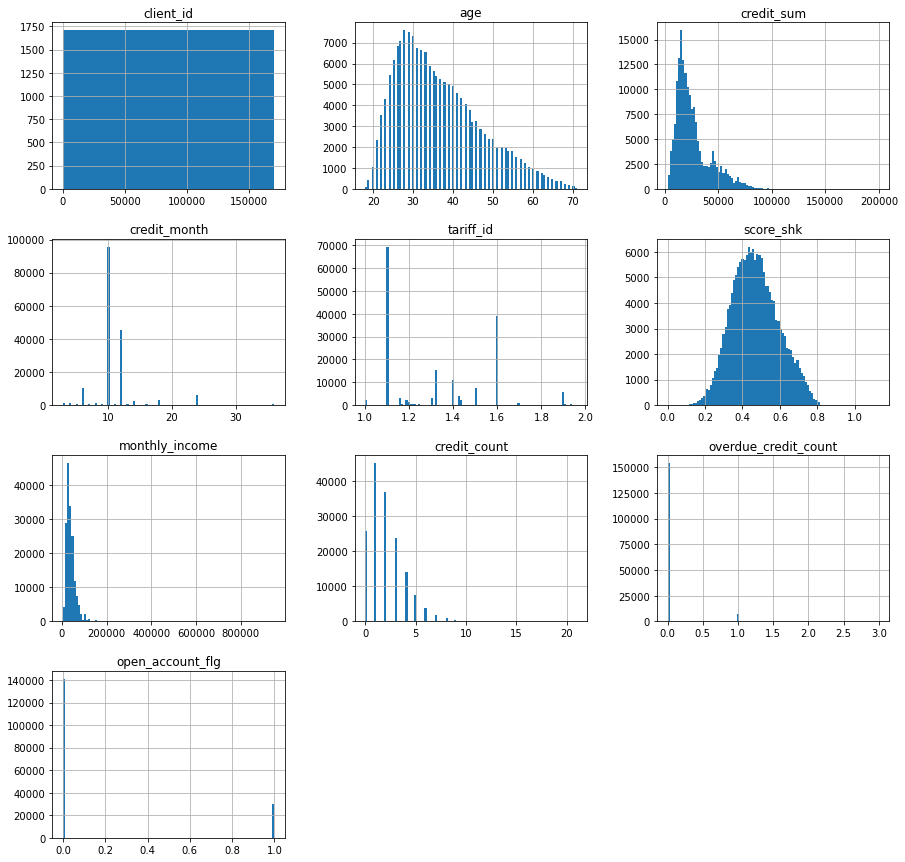

In [9]:
df.hist(bins=100, figsize=[15,15])

> В целом, в датасете выбросов нету, за исключением столбца tariff_id, который содержит множество выбросов(напр. просто значение "1.0" или некорректная дата 01.01.1932). И, судя по гистограмме половина всех заявок была подана в один день(чего, наверное, не может быть)

In [10]:
#удаляю дату заявки и регион проживания(т.к. данные столбца не вполне корректны)
df.drop(['living_region', 'tariff_id', 'client_id'], axis=1, inplace=True)

In [11]:
df['marital_status'].describe() # 3 пропуска

count     170743
unique         5
top          MAR
freq       93954
Name: marital_status, dtype: object

In [12]:
df['education'].describe() # 5 пропусков

count     170741
unique         5
top          SCH
freq       87537
Name: education, dtype: object

In [13]:
# заполняем пропуски наиболее распостраненным значением
df['marital_status'].fillna('MAR', inplace=True)
df['education'].fillna('SCH', inplace=True)

In [14]:
df['age'].describe() # 3 пропуска

count    170743.000000
mean         36.497262
std          10.546044
min          18.000000
25%          28.000000
50%          34.000000
75%          43.000000
max          71.000000
Name: age, dtype: float64

In [15]:
#заполняю пропуски медианным значением
df['age'].fillna(df['age'].median(), inplace=True)

In [16]:
df['credit_sum'].describe() # 2 пропуска

count    170744.000000
mean      26095.097541
std       16234.874095
min        2736.000000
25%       14908.000000
50%       21229.000000
75%       32068.000000
max      200000.000000
Name: credit_sum, dtype: float64

In [17]:
df['credit_sum'].fillna(df['credit_sum'].median(), inplace=True)

In [18]:
df['score_shk'].describe() # 7 пропусков

count    170739.000000
mean          0.469473
std           0.124265
min           0.000000
25%           0.379522
50%           0.461599
75%           0.552412
max           1.128291
Name: score_shk, dtype: float64

In [19]:
df['score_shk'].fillna(df['score_shk'].median(), inplace=True)

In [20]:
df['monthly_income'].describe() # 5 пропусков

count    170741.000000
mean      40138.596149
std       25044.373992
min        5000.000000
25%       25000.000000
50%       35000.000000
75%       50000.000000
max      950000.000000
Name: monthly_income, dtype: float64

In [21]:
df['monthly_income'].fillna(df['monthly_income'].median(), inplace=True)

In [22]:
df['credit_count'].describe() # 9230 пропусков

count    161516.000000
mean          2.107308
std           1.777128
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          21.000000
Name: credit_count, dtype: float64

In [23]:
#отсутствие значения может говорить либо о том, что не было кредитов у человека(тогда стоит заменить на 0), либо о том, что
#информация отсутствует(тогда следует заполнить медианным значением) я остановлюсь на втором варианте
df['credit_count'].fillna(df['credit_count'].median(), inplace=True)

In [24]:
#такая же история с колонкой просроченных кредитов
df['overdue_credit_count'].describe() # 9230 пропусков

count    161516.000000
mean          0.046070
std           0.211548
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: overdue_credit_count, dtype: float64

In [25]:
df['overdue_credit_count'].fillna(df['overdue_credit_count'].median(), inplace=True)

In [26]:
# результат очистки
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170746 non-null  float64
 2   marital_status        170746 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170746 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   score_shk             170746 non-null  float64
 7   education             170746 non-null  object 
 8   monthly_income        170746 non-null  float64
 9   credit_count          170746 non-null  float64
 10  overdue_credit_count  170746 non-null  float64
 11  open_account_flg      170746 non-null  int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 15.6+ MB


## Преобразование категориальных признаков

In [27]:
#делаю категориальные признаки числовыми
df = pd.concat([df, 
                      pd.get_dummies(df['gender'], prefix="gender"),
                      pd.get_dummies(df['job_position'], prefix="job_position"),
                      pd.get_dummies(df['education'], prefix="education"),
                      pd.get_dummies(df['marital_status'], prefix="marital_status")],
                     axis=1)

In [28]:
#удаляем старые категориальные столбцы
df.drop(['gender','job_position','education','marital_status'], axis=1, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   170746 non-null  float64
 1   credit_sum            170746 non-null  float64
 2   credit_month          170746 non-null  int64  
 3   score_shk             170746 non-null  float64
 4   monthly_income        170746 non-null  float64
 5   credit_count          170746 non-null  float64
 6   overdue_credit_count  170746 non-null  float64
 7   open_account_flg      170746 non-null  int64  
 8   gender_F              170746 non-null  uint8  
 9   gender_M              170746 non-null  uint8  
 10  job_position_ATP      170746 non-null  uint8  
 11  job_position_BIS      170746 non-null  uint8  
 12  job_position_BIU      170746 non-null  uint8  
 13  job_position_DIR      170746 non-null  uint8  
 14  job_position_HSK      170746 non-null  uint8  
 15  

## Корреляция

In [30]:
correlated_df = df.corr()
correlated_df

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,gender_M,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
age,1.000000,-0.096613,0.007099,-0.166308,-0.014882,0.114907,0.018358,-0.031062,0.125515,-0.125515,...,0.002925,-0.060480,-0.004834,0.119511,-0.126548,-0.021340,0.113880,0.132477,-0.281374,0.233198
credit_sum,-0.096613,1.000000,0.228323,0.054422,0.351489,0.014758,-0.005744,-0.072039,-0.034051,0.034051,...,0.008469,0.178917,0.019056,-0.188584,0.019239,-0.002036,-0.028003,-0.034525,0.066128,-0.032507
credit_month,0.007099,0.228323,1.000000,0.040373,0.007660,0.049284,0.006883,0.025809,-0.001861,0.001861,...,-0.005091,0.009146,0.013549,-0.007798,-0.005443,0.014266,-0.001696,-0.006156,0.001819,0.003705
score_shk,-0.166308,0.054422,0.040373,1.000000,-0.107255,-0.091858,0.155016,0.048686,0.012566,-0.012566,...,-0.013571,-0.248980,-0.036318,0.223321,0.059308,0.012165,0.008274,-0.148112,0.148719,0.005837
monthly_income,-0.014882,0.351489,0.007660,-0.107255,1.000000,0.144699,0.035451,-0.023697,-0.202281,0.202281,...,0.025594,0.214200,0.049318,-0.228756,0.021248,-0.005222,-0.011756,0.063737,-0.044432,-0.048985
credit_count,0.114907,0.014758,0.049284,-0.091858,0.144699,1.000000,0.177760,0.032374,0.014658,-0.014658,...,0.005705,0.031317,0.014551,-0.025285,-0.016322,0.007945,0.028363,0.056220,-0.089189,0.024049
overdue_credit_count,0.018358,-0.005744,0.006883,0.155016,0.035451,0.177760,1.000000,0.015913,-0.000476,0.000476,...,0.001519,0.023608,0.007612,-0.020420,-0.008283,0.003882,0.009835,0.020139,-0.030035,0.001925
open_account_flg,-0.031062,-0.072039,0.025809,0.048686,-0.023697,0.032374,0.015913,1.000000,-0.044265,0.044265,...,0.003788,-0.082371,0.002288,0.078337,0.005721,0.010666,0.005294,-0.067112,0.061312,0.013538
gender_F,0.125515,-0.034051,-0.001861,0.012566,-0.202281,0.014658,-0.000476,-0.044265,1.000000,-1.000000,...,-0.008705,0.075364,-0.007246,-0.063865,-0.020076,0.024858,0.113163,-0.093775,-0.015899,0.115216
gender_M,-0.125515,0.034051,0.001861,-0.012566,0.202281,-0.014658,0.000476,0.044265,-1.000000,1.000000,...,0.008705,-0.075364,0.007246,0.063865,0.020076,-0.024858,-0.113163,0.093775,0.015899,-0.115216


<AxesSubplot:>

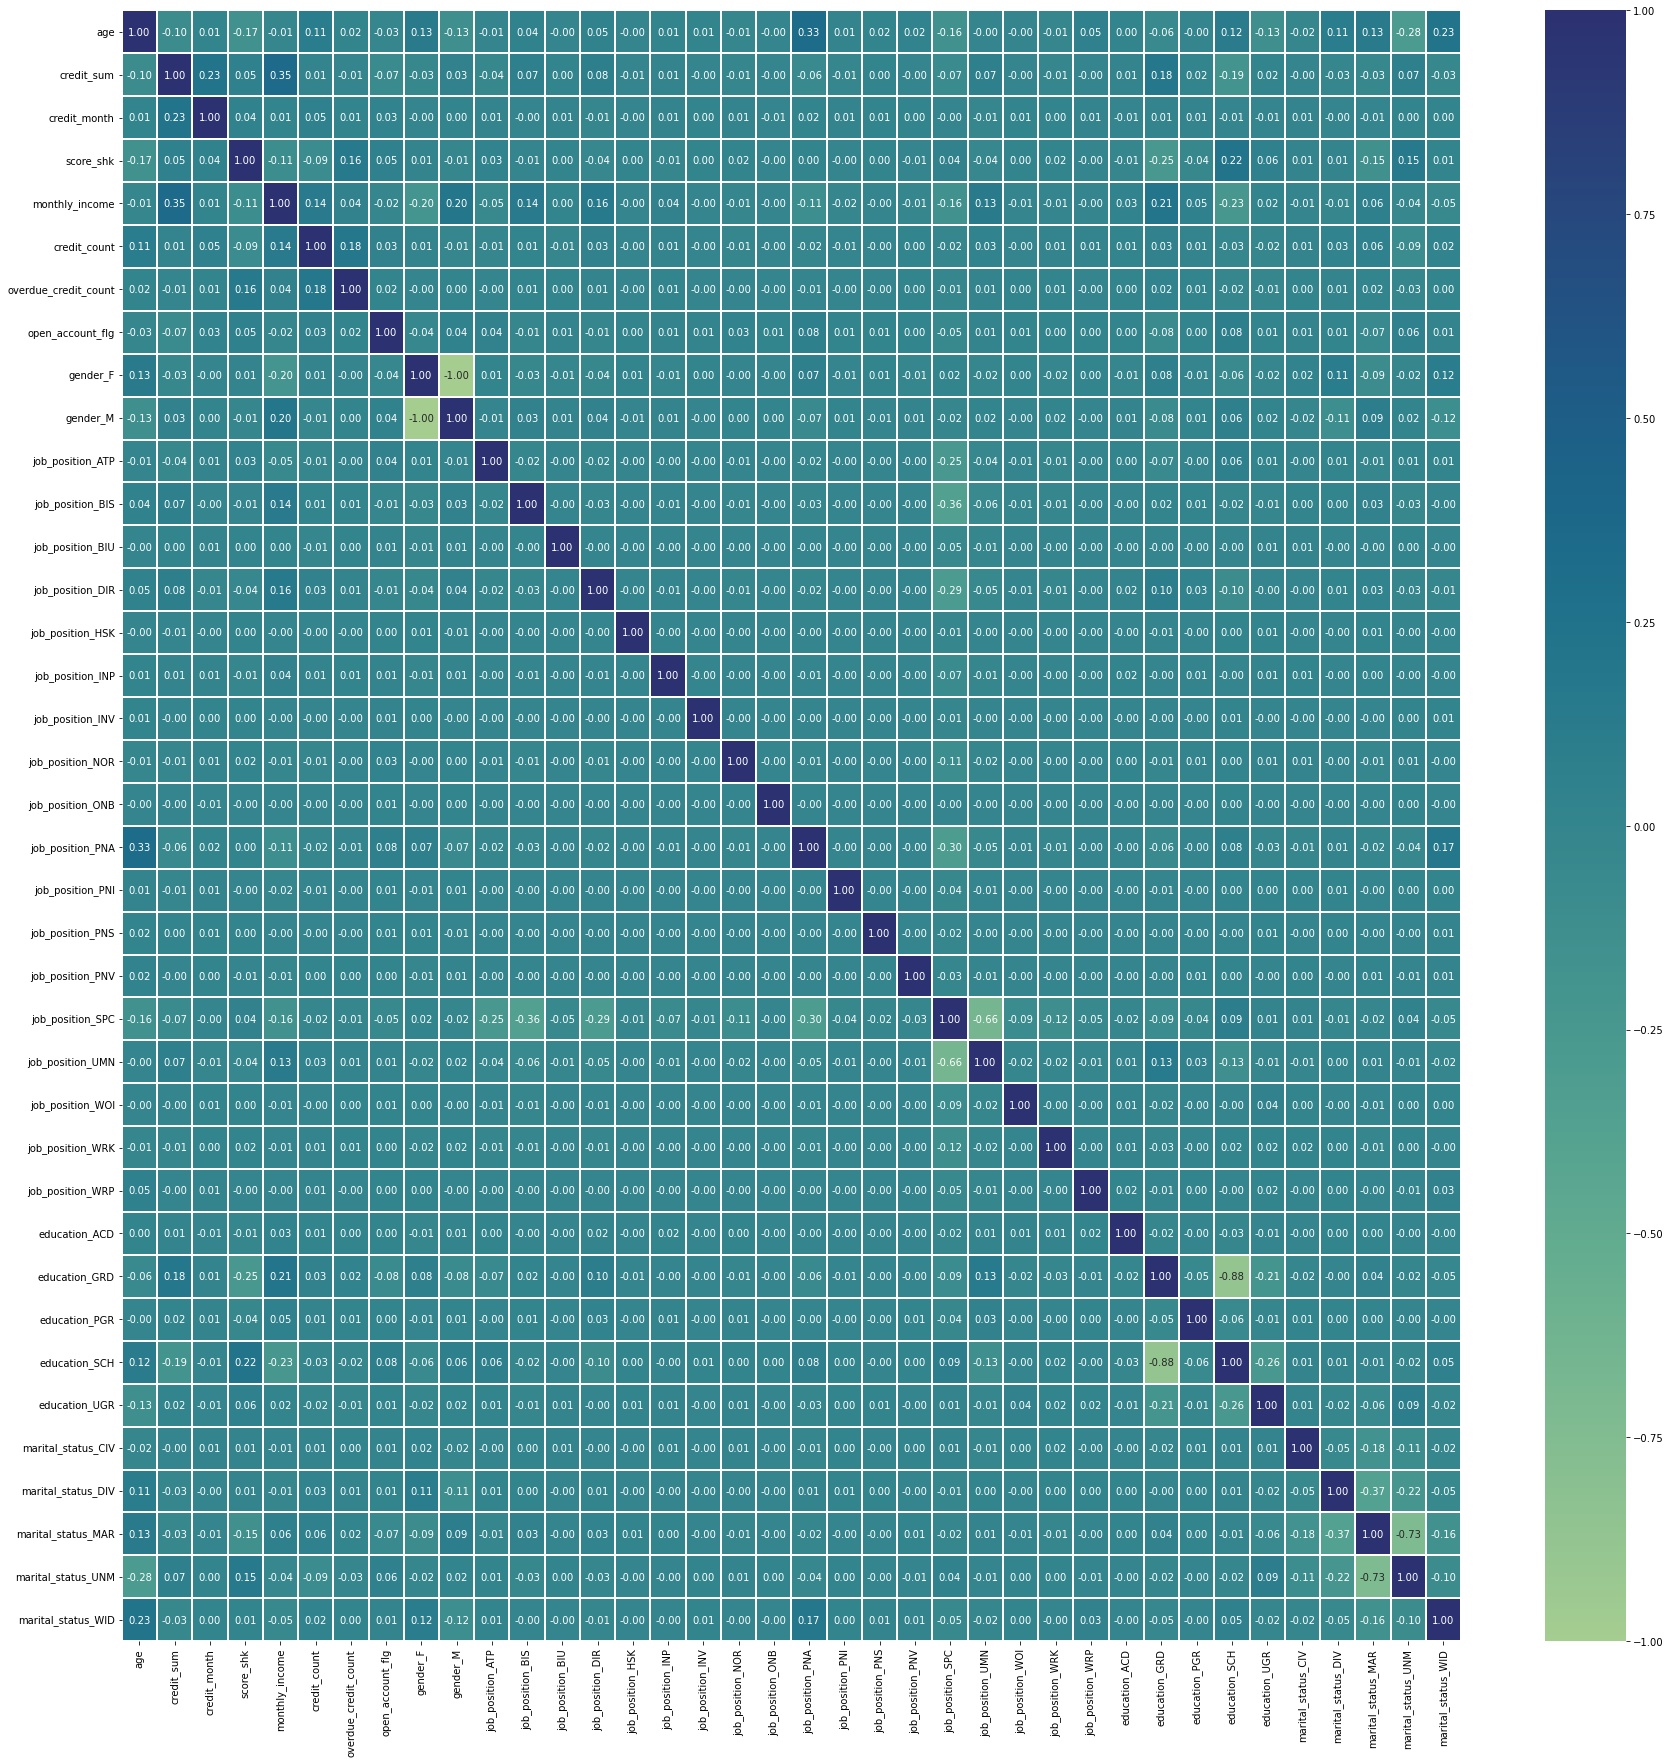

In [31]:
plt.subplots(figsize=(30,30))
sns.heatmap(correlated_df, annot=True, cmap="crest", fmt=".2f", linewidth=.2)

## Тест на нормальность распределения

In [32]:
for col in df:
    value = shapiro(df[col].tolist())
    print(str(col) + ' - ' + str(value))

C:\conda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


age - ShapiroResult(statistic=0.9502259492874146, pvalue=0.0)
credit_sum - ShapiroResult(statistic=0.8766595721244812, pvalue=0.0)
credit_month - ShapiroResult(statistic=0.6447504758834839, pvalue=0.0)
score_shk - ShapiroResult(statistic=0.9937583208084106, pvalue=0.0)
monthly_income - ShapiroResult(statistic=0.7270036339759827, pvalue=0.0)
credit_count - ShapiroResult(statistic=0.8740713000297546, pvalue=0.0)
overdue_credit_count - ShapiroResult(statistic=0.20412057638168335, pvalue=0.0)
open_account_flg - ShapiroResult(statistic=0.4614538550376892, pvalue=0.0)
gender_F - ShapiroResult(statistic=0.636896014213562, pvalue=0.0)
gender_M - ShapiroResult(statistic=0.6368135213851929, pvalue=0.0)
job_position_ATP - ShapiroResult(statistic=0.10337305068969727, pvalue=0.0)
job_position_BIS - ShapiroResult(statistic=0.16895455121994019, pvalue=0.0)
job_position_BIU - ShapiroResult(statistic=0.008791744709014893, pvalue=0.0)
job_position_DIR - ShapiroResult(statistic=0.127885639667511, pvalue=

> Поскольку pvalue каждого признака < 0.05, то ни один из признаков не подвергается нормальному распределению

## Масштабирование и стандартизация

In [33]:
num_cols = ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income',
       'credit_count', 'overdue_credit_count', 'open_account_flg']
cat_cols = ['gender_F',
       'gender_M', 'job_position_ATP', 'job_position_BIS', 'job_position_BIU',
       'job_position_DIR', 'job_position_HSK', 'job_position_INP',
       'job_position_INV', 'job_position_NOR', 'job_position_ONB',
       'job_position_PNA', 'job_position_PNI', 'job_position_PNS',
       'job_position_PNV', 'job_position_SPC', 'job_position_UMN',
       'job_position_WOI', 'job_position_WRK', 'job_position_WRP',
       'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH',
       'education_UGR', 'marital_status_CIV', 'marital_status_DIV',
       'marital_status_MAR', 'marital_status_UNM', 'marital_status_WID']

In [34]:
scaler = StandardScaler()

In [35]:
df_num = scaler.fit_transform(df[num_cols])
df_cat = scaler.fit_transform(df[cat_cols])

In [36]:
df_num = pd.DataFrame(df_num, index=df.index, columns=num_cols)
df_cat = pd.DataFrame(df_cat, index=df.index, columns=cat_cols)

In [37]:
np_df = np.column_stack((df_num,df_cat))

In [38]:
#обратно в dataFrame
df = pd.DataFrame(np_df, index=df.index, columns=df.columns)

## Деление датасета и построение модели

In [66]:
y = df['open_account_flg']
x = df.drop(('open_account_flg'), axis=1)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=21)

In [68]:
#без этой ячейки выдает ошибку: ValueError: Unknown label type: 'continuous'
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [73]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 10,  max_depth=5,  random_state=21)
rfc.fit(x_train, y_train)
rfc.score(x_test, y_test)

0.8250429486178353

In [74]:
y_pred = rfc.predict_proba(x_test)[:, 1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.6537913139288563